In [433]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, random
warnings.filterwarnings(action='ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, log_loss
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb

In [434]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv', index_col='index')

In [435]:
train.drop(['FLAG_MOBIL'], axis=1, inplace=True)
train.fillna('NaN', inplace=True) 

test.drop(['FLAG_MOBIL'], axis=1, inplace=True)
test.fillna('NaN', inplace=True)


In [436]:
train = train[(train['family_size'] <= 7)]
train.set_index('index', inplace=True)
train = train.reset_index(drop=True)

### 음수값 -> 양수 변환

In [437]:
feats = ['DAYS_BIRTH', 'begin_month', 'DAYS_EMPLOYED']
for feat in feats:
    train[feat]=-train[feat]
    test[feat]=-test[feat]

<AxesSubplot:>

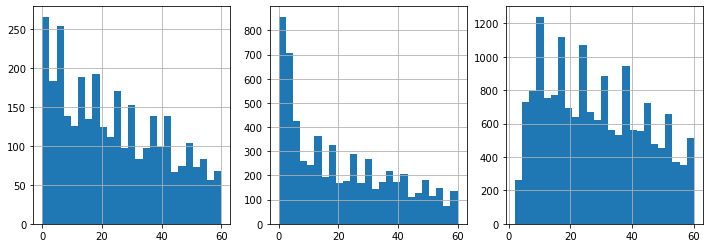

In [428]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
train['begin_month'][train['credit']==0].hist(bins=25, ax=axes[0])
train['begin_month'][train['credit']==1].hist(bins=25, ax=axes[1])
train['begin_month'][train['credit']==2].hist(bins=25, ax=axes[2])


In [429]:
# train['begin_month_log1p'] = np.log1p(1+train['begin_month'])

KeyError: 'begin_month_log1p'

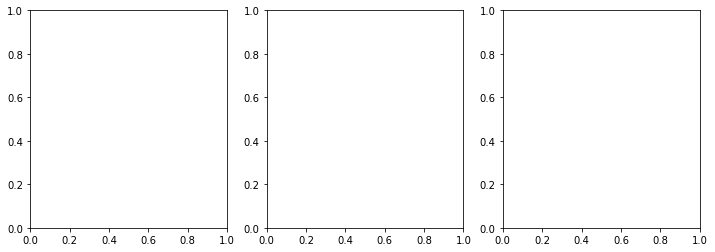

In [430]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
train['begin_month_log1p'][train['credit']==0].hist(bins=25, ax=axes[0])
train['begin_month_log1p'][train['credit']==1].hist(bins=25, ax=axes[1])
train['begin_month_log1p'][train['credit']==2].hist(bins=25, ax=axes[2])

In [ ]:
# train['begin_month_log'] = np.log(1+train['begin_month'])

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
train['begin_month_log'][train['credit']==0].hist(bins=25, ax=axes[0])
train['begin_month_log'][train['credit']==1].hist(bins=25, ax=axes[1])
train['begin_month_log'][train['credit']==2].hist(bins=25, ax=axes[2])

In [ ]:
train.loc[train["income_type"] == "Pensioner", 'occyp_type']

In [ ]:
pd.qcut(train['begin_month'], q=8).value_counts() 

In [ ]:
# train_corr = train.corr()
# ax = plt.subplots(figsize=(30, 25))
# ax = sns.heatmap(train_corr, center=0, annot = True, linewidths=.5)

### Feature Engineering

In [438]:
for df in [train,test]:
    df['DAYS_BIRTH_DAYS_EMPLOYED_ratio'] = df['DAYS_BIRTH'] / df['DAYS_EMPLOYED']
    df['income_total_DAYS_BIRTH_ratio'] = df['income_total'] / df['DAYS_BIRTH']
    df['income_total_DAYS_EMPLOYED_ratio'] = df['income_total'] / df['DAYS_EMPLOYED']
    df['parents'] = df['family_size'] - df['child_num']
    df['before_EMPLOYED'] = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED']
    df['income_total_workingday_ratio'] = df['income_total'] / df['before_EMPLOYED']
    
    df["DAYS_BIRTH_m"] = np.floor((df["DAYS_BIRTH"]) / 30) - ((np.floor((df["DAYS_BIRTH"]) / 30) / 12).astype(int) * 12)
    df["DAYS_BIRTH_w"] = np.floor((df["DAYS_BIRTH"]) / 7) - ((np.floor((df["DAYS_BIRTH"]) / 7) / 4).astype(int) * 4)
    df["Age"] = (df["DAYS_BIRTH"] / 360).astype(int)
    
    df["before_EMPLOYED_m"] = np.floor((df["before_EMPLOYED"]) / 30) - ((np.floor((df["before_EMPLOYED"]) / 30) / 12).astype(int) * 12)
    df["before_EMPLOYED_w"] = np.floor((df["before_EMPLOYED"]) / 7) - ((np.floor((df["before_EMPLOYED"]) / 7) / 4).astype(int) * 4)
    
    
    df["EMPLOYED"] = df["DAYS_EMPLOYED"] / 360
    df["DAYS_EMPLOYED"] = df["DAYS_EMPLOYED"].map(lambda x: 0 if x < 0 else x)
    df['ability'] = df['income_total'] / (df['DAYS_BIRTH'] + df['DAYS_EMPLOYED'])
    df['income_mean'] = df['income_total'] / df['family_size']
    
    df['G_C_R'] = (df['gender'].astype(str)
        + "_" + df['car'].astype(str)
        + "_" + df['reality'].astype(str))

    #df['income_total_family_size_ratio'] = df['income_total'] / df['family_size']

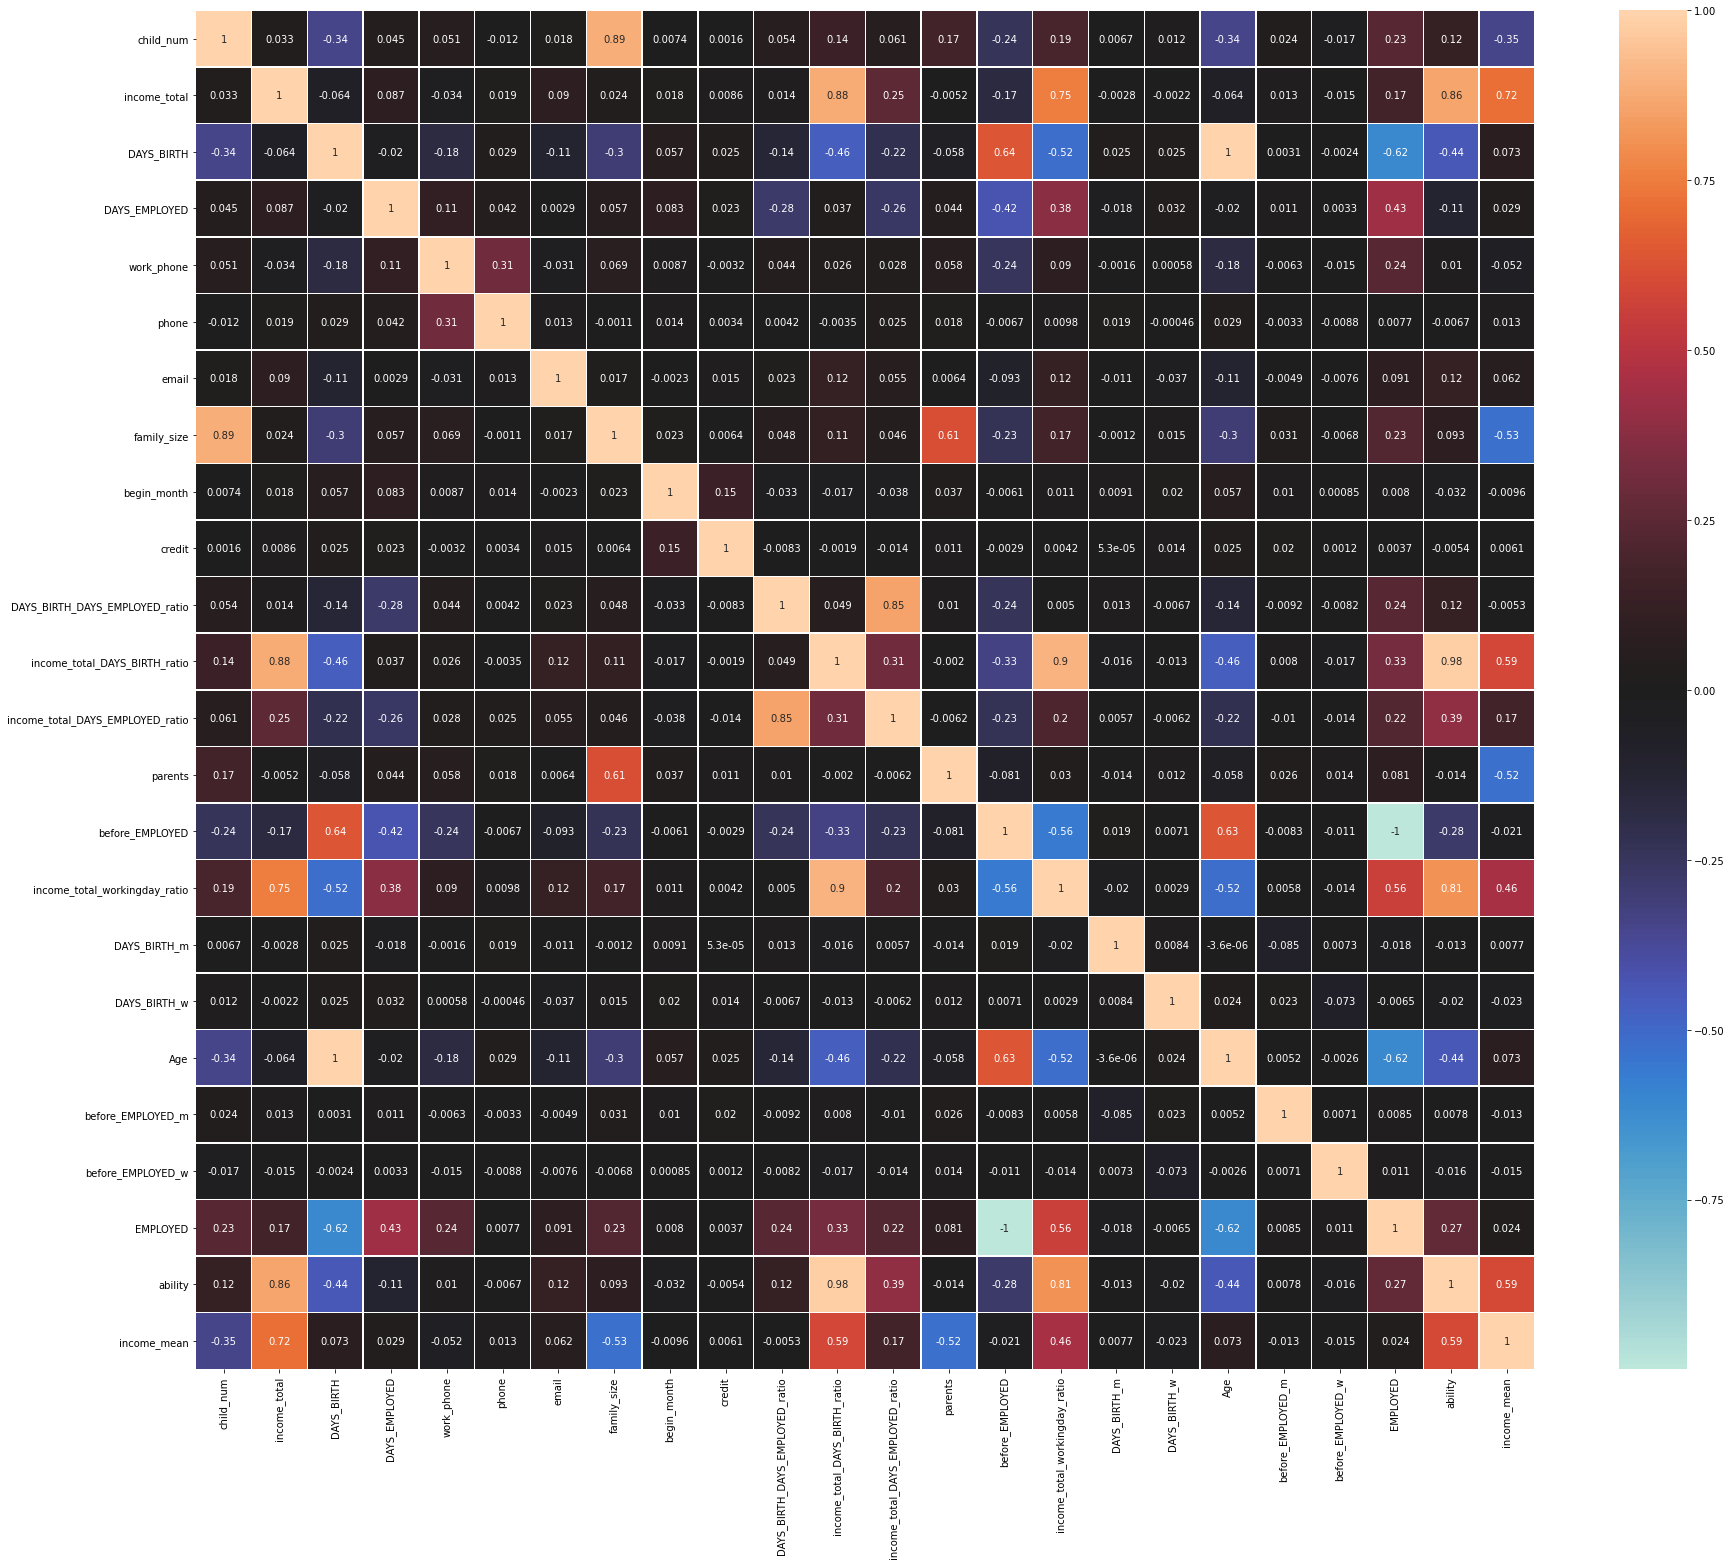

In [439]:
train_corr = train.corr()
ax = plt.subplots(figsize=(30, 25))
ax = sns.heatmap(train_corr, center=0, annot = True, linewidths=.5)

In [440]:
for df in [train,test]:
    df["contact"] = df["email"].astype(str)+df["phone"].astype(str)+ df["work_phone"].astype(str)
    df["info"] = df["gender"].astype(str)+df["occyp_type"].astype(str)+ df["edu_type"].astype(str)
ID_columns = ["contact", "info"]
for feat in ID_columns:
    order= train[feat][train["credit"]==2].value_counts(normalize= True, sort= True).index
    mapping = {}
    for index, value in enumerate(order):
        mapping[value]= index
    train[feat] = train[feat].map(mapping)
    test[feat] = test[feat].map(mapping)

In [ ]:
# train['ID'] = \
# train['child_num'].astype(str) + '_' + train['income_total'].astype(str) + '_' +\
# train['DAYS_BIRTH'].astype(str) + '_' + train['DAYS_EMPLOYED'].astype(str) + '_' +\
# train['work_phone'].astype(str) + '_' + train['phone'].astype(str) + '_' +\
# train['email'].astype(str) + '_' + train['family_size'].astype(str) + '_' +\
# train['gender'].astype(str) + '_' + train['car'].astype(str) + '_' +\
# train['reality'].astype(str) + '_' + train['income_type'].astype(str) + '_' +\
# train['edu_type'].astype(str) + '_' + train['family_type'].astype(str) + '_' +\
# train['house_type'].astype(str) + '_' + train['occyp_type'].astype(str)

# test['ID'] = \
# test['child_num'].astype(str) + '_' + test['income_total'].astype(str) + '_' +\
# test['DAYS_BIRTH'].astype(str) + '_' + test['DAYS_EMPLOYED'].astype(str) + '_' +\
# test['work_phone'].astype(str) + '_' + test['phone'].astype(str) + '_' +\
# test['email'].astype(str) + '_' + test['family_size'].astype(str) + '_' +\
# test['gender'].astype(str) + '_' + test['car'].astype(str) + '_' +\
# test['reality'].astype(str) + '_' + test['income_type'].astype(str) + '_' +\
# test['edu_type'].astype(str) + '_' + test['family_type'].astype(str) + '_' +\
# test['house_type'].astype(str) + '_' + test['occyp_type'].astype(str)

In [ ]:
# le = LabelEncoder()
# train['ID'] = le.fit_transform(train['ID'])
# test.loc[~test['ID'].isin(le.classes_),'ID'] = -1
# test.loc[test['ID'].isin(le.classes_),'ID'] = le.transform(test['ID'][test['ID'].isin(le.classes_)])

In [ ]:
# test = test.astype({'ID': 'int32'})

In [ ]:
# open_month = pd.DataFrame(train.groupby('ID')['begin_month'].min(), index=train.groupby('ID')['begin_month'].min().index)
# open_month= open_month.astype('int')
# open_month.columns = ['open_month']
# om_dict = open_month.open_month.to_dict()

# train['open_month'] = train["ID"]
# train['open_month'] = train['open_month'].map(om_dict)

In [ ]:
# open_month = pd.DataFrame(test.groupby('ID')['begin_month'].min(), index=test.groupby('ID')['begin_month'].min().index)
# open_month= open_month.astype('int')
# open_month.columns = ['open_month']
# om_dict = open_month.open_month.to_dict()

# test['open_month'] = test["ID"]
# test['open_month'] = test['open_month'].map(om_dict)

In [ ]:
#train.sort_values(by=['index'], axis=0, inplace=True, ignore_index=True)
#test.sort_values(by=['index'], axis=0, inplace=True, ignore_index=True)

In [ ]:
#train.drop(['ID'], axis=1, inplace=True)
#test.drop(['ID'], axis=1, inplace=True)

In [ ]:
#new_data=pd.DataFrame(train.groupby(["ID"])["begin_month"].agg(min))
#new_data

### Feature importance 떨어지는 컬럼 삭제

In [441]:
def days_to_age(x):
    return x/365

bins = np.arange(2, 8)*10
labels = [str(s)+'\'s' for s in bins[:-1]]
train['age_groups'] = pd.cut(train['DAYS_BIRTH'].apply(days_to_age), bins, labels=labels)
test['age_groups'] = pd.cut(test['DAYS_BIRTH'].apply(days_to_age), bins, labels=labels)


encoder = LabelEncoder()
train['age_groups'] = encoder.fit_transform(train['age_groups'])
test['age_groups'] = encoder.transform(test['age_groups'])

In [442]:
del_cols = [
    'gender',
    'car',
    'reality',
    'child_num',
    'DAYS_BIRTH',
    'DAYS_EMPLOYED',
    'parents',
#     'before_EMPLOYED',
#     'ability',
    #'income_type', 'edu_type', 'family_size', 'phone', 'house_type', 'work_phone', 'email',

]

train.drop(del_cols, axis=1, inplace=True)
test.drop(del_cols, axis=1, inplace=True)

In [443]:
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
numerical_feats.remove('credit')
# numerical_feats.remove('ID')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

total_feats = numerical_feats + categorical_feats

Number of Numerical features:  22
Number of Categorical features:  6


## LabelEncoding, Scaling

In [389]:
numerical_feats

['income_total',
 'work_phone',
 'phone',
 'email',
 'family_size',
 'begin_month',
 'DAYS_BIRTH_DAYS_EMPLOYED_ratio',
 'income_total_DAYS_EMPLOYED_ratio',
 'before_EMPLOYED',
 'income_total_workingday_ratio',
 'DAYS_BIRTH_m',
 'DAYS_BIRTH_w',
 'Age',
 'before_EMPLOYED_m',
 'before_EMPLOYED_w',
 'EMPLOYED',
 'ability',
 'income_mean',
 'contact',
 'info',
 'age_groups']

In [390]:
categorical_feats

['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'G_C_R']

In [413]:
for df in [train,test]:
    df['income_total'] = np.log1p(1+df['income_total'])
#    df['DAYS_EMPLOYED'] = np.loglp(1+df['DAYS_EMPLOYED'])
    


In [414]:
#begin_month 변환 X

In [444]:
for feat in categorical_feats:
    encoder = LabelEncoder()
    train[feat] = encoder.fit_transform(train[feat])
    test[feat] = encoder.transform(test[feat])

In [445]:
numerical_feats.remove('begin_month')
# numerical_feats.remove('age_groups')
# numerical_feats.remove('income_total')
scaler = StandardScaler()
train[total_feats] = scaler.fit_transform(train[total_feats])
test[total_feats] = scaler.transform(test[total_feats])


## Modeling

In [446]:
n_est = 1000
seed = 42
n_fold = 5
n_class = 3

rf_params = {
    'max_depth': 16,
    'min_samples_leaf': 8,
    'random_state': seed
}

# lgb_params = {
#     'metric': 'multi_logloss',
#     'n_estimators': n_est,
#     'objective': 'multiclass',
#     'random_state': seed,
#     'learning_rate': 0.01,
#     'min_child_samples': 20,
#     'reg_alpha': 3e-5,
#     'reg_lambda': 9e-2,
#     'num_leaves': 127,
#     'colsample_bytree': 0.8,
#     'subsample': 0.8,
#     'num_class': n_class,
#     'early_stopping_rounds':500,
#     'n_jobs':-1,
#     'max_depth':-1,
# }

lgb_params = {
                    'objective':'multiclass',
                    'num_class': n_class,
                    'boosting_type':'gbdt',
                    'metric':'multi_logloss',
                    'n_jobs':-1,
                    'learning_rate':0.01,
                    'num_leaves': 127,
                    'max_depth':-1,
                    'tree_learner':'serial',
                    "min_child_weight": 0.01,
                    'colsample_bytree': 0.7,
                    'subsample_freq':1,
                    'subsample':0.5,
                    'n_estimators':1000,
                    'max_bin':800,
                    'verbose':-1,
                    'seed': seed,
                    #'early_stopping_rounds':300, 
                }

In [447]:
models = {#'RF': RandomForestClassifier(**rf_params), 
               'LGBM': LGBMClassifier(**lgb_params),
}

In [448]:
target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test

In [449]:
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

pred_dic = {}
pred_test_dic = {}
        
for name in models:
    print(f'Training {name}:')
    pred = np.zeros((X.shape[0], 3), dtype=float)
    pred_test = np.zeros((X_test.shape[0], 3), dtype=float)
    for fold in range(5):
        train_idx, valid_idx = folds[fold]
        X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
        models[name].fit(X_train, y_train)
        pred[valid_idx] = models[name].predict_proba(X_valid)
        pred_test += models[name].predict_proba(X_test) / 5
        
    pred_dic[name] = pred
    pred_test_dic[name] = pred_test
    print(f'\tCV Log Loss: {log_loss(y, pred):.6f}')

Training LGBM:
	CV Log Loss: 0.702145


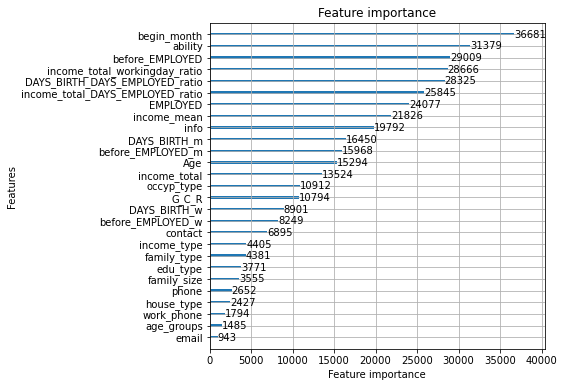

In [421]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

f, ax = plt.subplots(figsize=(6, 6))
plot_importance(models['LGBM'], ax=ax)
plt.savefig('Feature importance_새로운EDA추가.png')

In [422]:

pred_df = pd.DataFrame(data=pred_test_dic['LGBM'])
pred_df

sub = pd.read_csv('sample_submission.csv', index_col='index')
sub[sub.columns] = pred_df.values
sub.to_csv('submission0503_EDA다시한것.csv')

In [ ]:
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

pred_dic = {}
pred_test_dic = {}
        
for name in models:
    print(f'Training {name}:')
    pred = np.zeros((X.shape[0], n_class), dtype=float)
    pred_test = np.zeros((X_test.shape[0], n_class), dtype=float)
    for fold in range(n_fold):
        train_idx, valid_idx = folds[fold]
        X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
        models[name].fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_valid, y_valid)],
            early_stopping_rounds=100,
            verbose=100,)
        pred[valid_idx] = models[name].predict_proba(X_valid)
        pred_test += models[name].predict_proba(X_test) / n_fold
        
    pred_dic[name] = pred
    pred_test_dic[name] = pred_test
    print(f'\tCV Log Loss: {log_loss(y, pred):.6f}')

### make_test 함수 활용 -> Fold 시도 : 실패

In [ ]:
# old_score=0
    
# y_preds = np.zeros((X.shape[0],n_class))
# test_preds = np.zeros((X_test.shape[0], n_class))
    
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [ ]:
# for i_cv, (i_trn, i_val) in enumerate(cv.split(X, y)):
#     tr_data = lgb.Dataset(X.iloc[i_trn], label=y.iloc[i_trn])
#     #vl_data = lgb.Dataset(X_val.iloc[i_trn], label=y_val.iloc[i_trn]) 
#     estimator = lgb.train(
#             lgb_params,
#             tr_data,
#             #valid_sets = [tr_data, vl_data],
#             verbose_eval = 100,
#         )
#     y_preds[i_val] = estimator.predict(X.iloc[i_val])

#     test_preds += estimator.predict(X_test) / n_fold
    
# skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# folds=[]
# for train_idx, valid_idx in skfold.split(X, y):
#         folds.append((train_idx, valid_idx))
# for fold in range(5):
#     train_idx, valid_idx = folds[fold]
#     X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
#     tr_data = lgb.Dataset(X.iloc[i_trn], label=y.iloc[i_trn])
#     estimator = lgb.train(
#             lgb_params,
#             tr_data,
#             #valid_sets = [tr_data, vl_data],
#             verbose_eval = 100,
#         )
#     pred[valid_idx] = models[name].predict_proba(X_valid)
#     pred_test += models[name].predict_proba(X_test) / 5

In [ ]:
# feature_imp = pd.DataFrame(sorted(zip(estimator.feature_importance(),X.columns)), columns=['Value','Feature'])
     
# m_results = []
# print('#'*20)
  
# g_logloss = log_loss(y, y_preds)
# score_diff = g_logloss - old_score
# print('Global log loss', g_logloss)
# m_results.append(g_logloss)
    
# print('#'*20)
# print('Features Preformance:', g_logloss)
# print('Diff with previous__:', score_diff)

In [ ]:
# test_preds

In [ ]:
# pred_df = pd.DataFrame(data=test_preds)
# pred_df

# sub = pd.read_csv('sample_submission.csv', index_col='index')
# sub[sub.columns] = pred_df.values
# sub.to_csv('submission0501.csv')